In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class RSIBacktester(): 
    ''' Class for the vectorized backtesting of RSI-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    periods: int
        time window in days to calculate moving average UP & DOWN 
    rsi_upper: int
        upper rsi band indicating overbought instrument
    rsi_lower: int
        lower rsi band indicating oversold instrument
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets new RSI parameter(s)
        
    test_strategy:
        runs the backtest for the RSI-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates RSI parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the three RSI parameters
    '''
    
    def __init__(self, symbol, periods, rsi_upper, rsi_lower, start, end, tc):
        self.symbol = symbol
        self.periods = periods
        self.rsi_upper = rsi_upper
        self.rsi_lower = rsi_lower
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "RSIBacktester(symbol = {}, RSI({}, {}, {}), start = {}, end = {})".format(self.symbol, self.periods, self.rsi_upper, self.rsi_lower, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["U"] = np.where(raw.price.diff() > 0, raw.price.diff(), 0) 
        raw["D"] = np.where(raw.price.diff() < 0, -raw.price.diff(), 0)
        raw["MA_U"] = raw.U.rolling(self.periods).mean()
        raw["MA_D"] = raw.D.rolling(self.periods).mean()
        raw["RSI"] = raw.MA_U / (raw.MA_U + raw.MA_D) * 100
        self.data = raw 
        
    def set_parameters(self, periods = None, rsi_upper = None, rsi_lower = None):
        ''' Updates RSI parameters and resp. time series.
        '''
        if periods is not None:
            self.periods = periods     
            self.data["MA_U"] = self.data.U.rolling(self.periods).mean()
            self.data["MA_D"] = self.data.D.rolling(self.periods).mean()
            self.data["RSI"] = self.data.MA_U / (self.data.MA_U + self.data.MA_D) * 100
            
        if rsi_upper is not None:
            self.rsi_upper = rsi_upper
            
        if rsi_lower is not None:
            self.rsi_lower = rsi_lower
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data.RSI > self.rsi_upper, -1, np.nan)
        data["position"] = np.where(data.RSI < self.rsi_lower, 1, data.position)
        data.position = data.position.fillna(0)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | RSI ({}, {}, {}) | TC = {}".format(self.symbol, self.periods, self.rsi_upper, self.rsi_lower, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, RSI):
        ''' Updates RSI parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        RSI: tuple
            RSI parameter tuple
        '''
        self.set_parameters(int(RSI[0]), int(RSI[1]), int(RSI[2]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, periods_range, rsi_upper_range, rsi_lower_range):
        ''' Finds global maximum given the RSI parameter ranges.

        Parameters
        ==========
        periods_range, rsi_upper_range, rsi_lower_range : tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (periods_range, rsi_upper_range, rsi_lower_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [8]:
tester = RSIBacktester("EURUSD=X", periods = 14, rsi_upper = 70, rsi_lower = 30, start = "2004-01-01", end = "2020-06-30", tc = 0.0007)

In [9]:
tester

RSIBacktester(symbol = EURUSD=X, RSI(14, 70, 30), start = 2004-01-01, end = 2020-06-30)

In [10]:
tester.test_strategy()

(0.957047, 0.063637)

In [11]:
tester.results

,price,returns,U,D,MA_U,MA_D,RSI,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,,
2004-01-21,1.265903,0.005542,0.006996,0.000000,0.005050,0.004499,52.883143,0.0,0.0,0.0,1.005557,1.000000
2004-01-22,1.272508,0.005204,0.006605,0.000000,0.005522,0.004499,55.101281,0.0,0.0,0.0,1.010804,1.000000
2004-01-23,1.258305,-0.011224,0.000000,0.014203,0.004771,0.005514,46.391264,0.0,-0.0,0.0,0.999522,1.000000
2004-01-26,1.248798,-0.007584,0.000000,0.009507,0.004528,0.006193,42.236624,0.0,-0.0,0.0,0.991970,1.000000
2004-01-27,1.263695,0.011859,0.014897,0.000000,0.005592,0.005621,49.872805,0.0,0.0,0.0,1.003804,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,0.003267,0.000000,0.002731,0.002185,55.549782,0.0,0.0,0.0,0.898585,0.957047
2020-06-25,1.125087,-0.005449,0.000000,0.006147,0.002003,0.002624,43.285211,0.0,-0.0,0.0,0.893702,0.957047
2020-06-26,1.122208,-0.002562,0.000000,0.002879,0.002003,0.002699,42.598962,0.0,-0.0,0.0,0.891415,0.957047


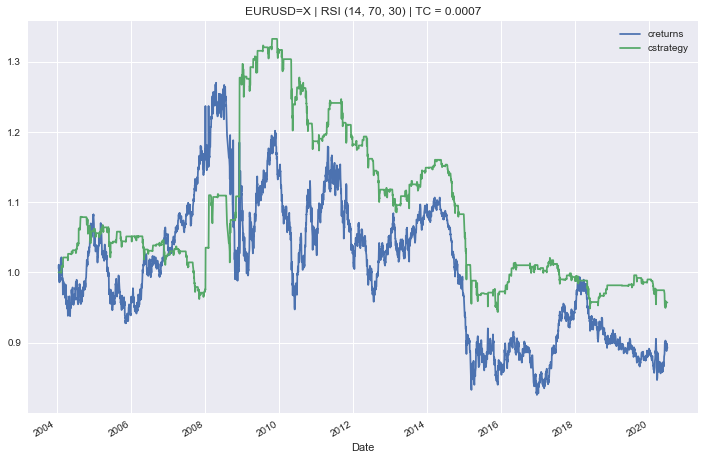

In [12]:
tester.plot_results()

In [13]:
tester.optimize_parameters((5, 20, 1), (65, 80, 1), (20, 35, 1))

(array([19., 72., 30.]), 1.37152)

In [14]:
tester.test_strategy()

(1.37152, 0.481495)

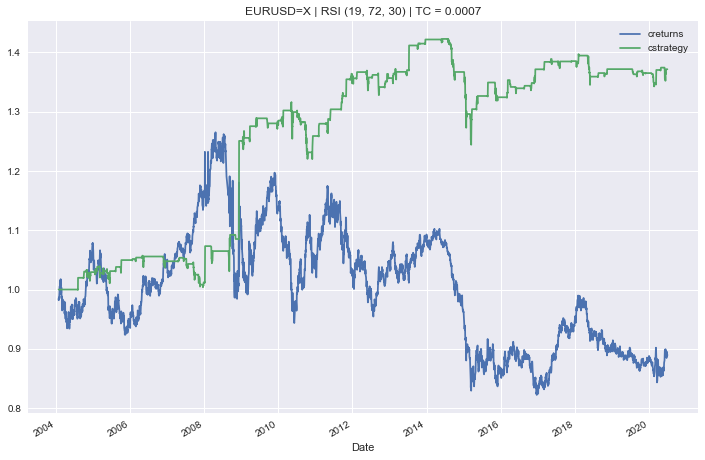

In [15]:
tester.plot_results()

In [16]:
tester.optimize_parameters((20, 50, 1), (75, 85, 1), (15, 25, 1))

(array([26., 75., 24.]), 1.172467)

In [17]:
tester.test_strategy()

(1.172467, 0.277843)

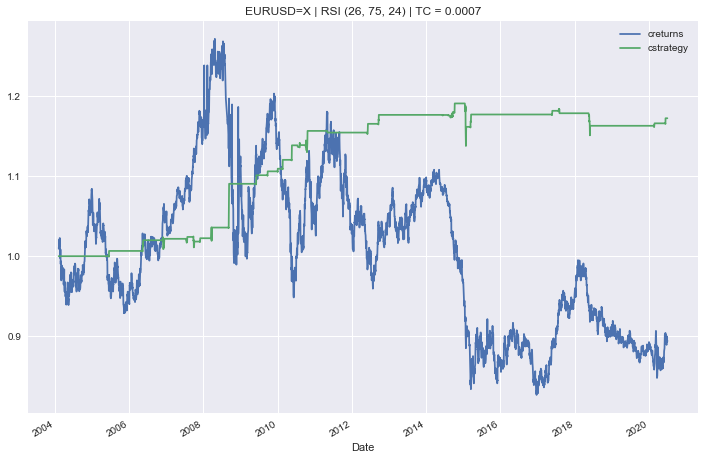

In [18]:
tester.plot_results()